Running a Tobit style regression in Stan.

In [1]:
# set up Python
from typing import Iterable
import logging
import numpy as np
import pandas as pd
from plotnine import *
from cmdstanpy import CmdStanModel
from sklearn.linear_model import LinearRegression

# quiet down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())

In [2]:
rng = np.random.default_rng(2024)

In [3]:
# from 
# https://win-vector.com/2024/08/16/post-hoc-adjustment-for-zero-thresholded-linear-models/
def trueprocess(mu: float, N: int =1000):
  x = rng.normal(size=N, loc=mu)
  xnoise = x + rng.normal(size=N)
  y = np.maximum(0.0, xnoise)
  concept = np.maximum(0.0, x)
  df = pd.DataFrame({'x': x, 'y': y, 'concept': concept})
  return df

traind = trueprocess(mu=0, N=1000)


traind.head()

,x,y,concept
0,1.028857,1.909897,1.028857
1,1.641920,0.797920,1.641920
2,1.146720,0.000000,1.146720
3,-0.973180,0.000000,0.000000
4,-1.392800,0.000000,0.000000


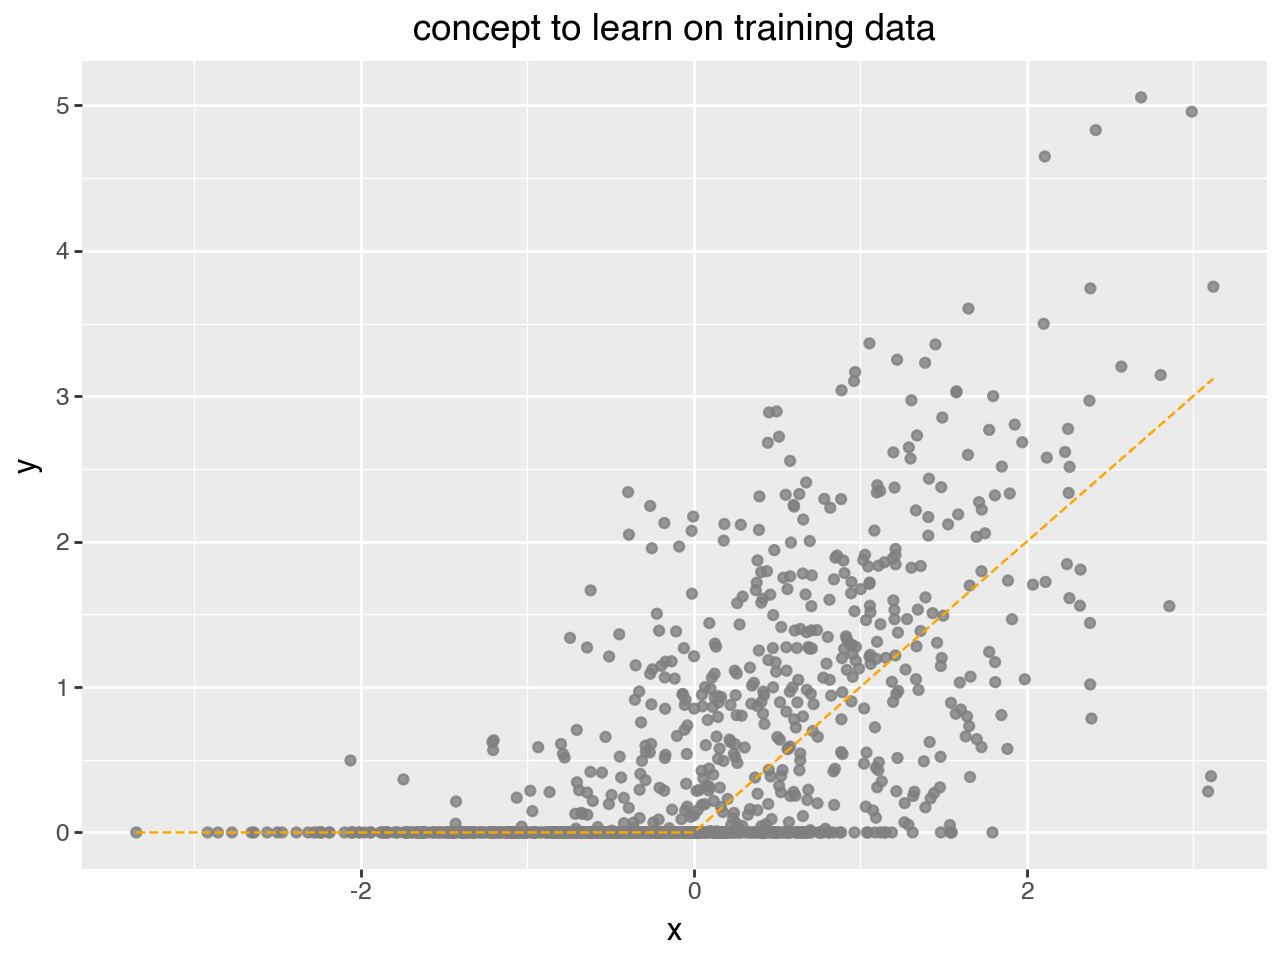

In [4]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) + 
    geom_line(
        mapping=aes(y='concept'),
        color="orange", linetype='--') + 
    ggtitle("concept to learn on training data")
)

In [5]:

lm0 = LinearRegression()
lm0.fit(
    traind.loc[:, ['x']],
    traind.loc[:, 'y'],
)
traind['ypred0'] = np.maximum(0, lm0.predict(traind.loc[:, ['x']]))

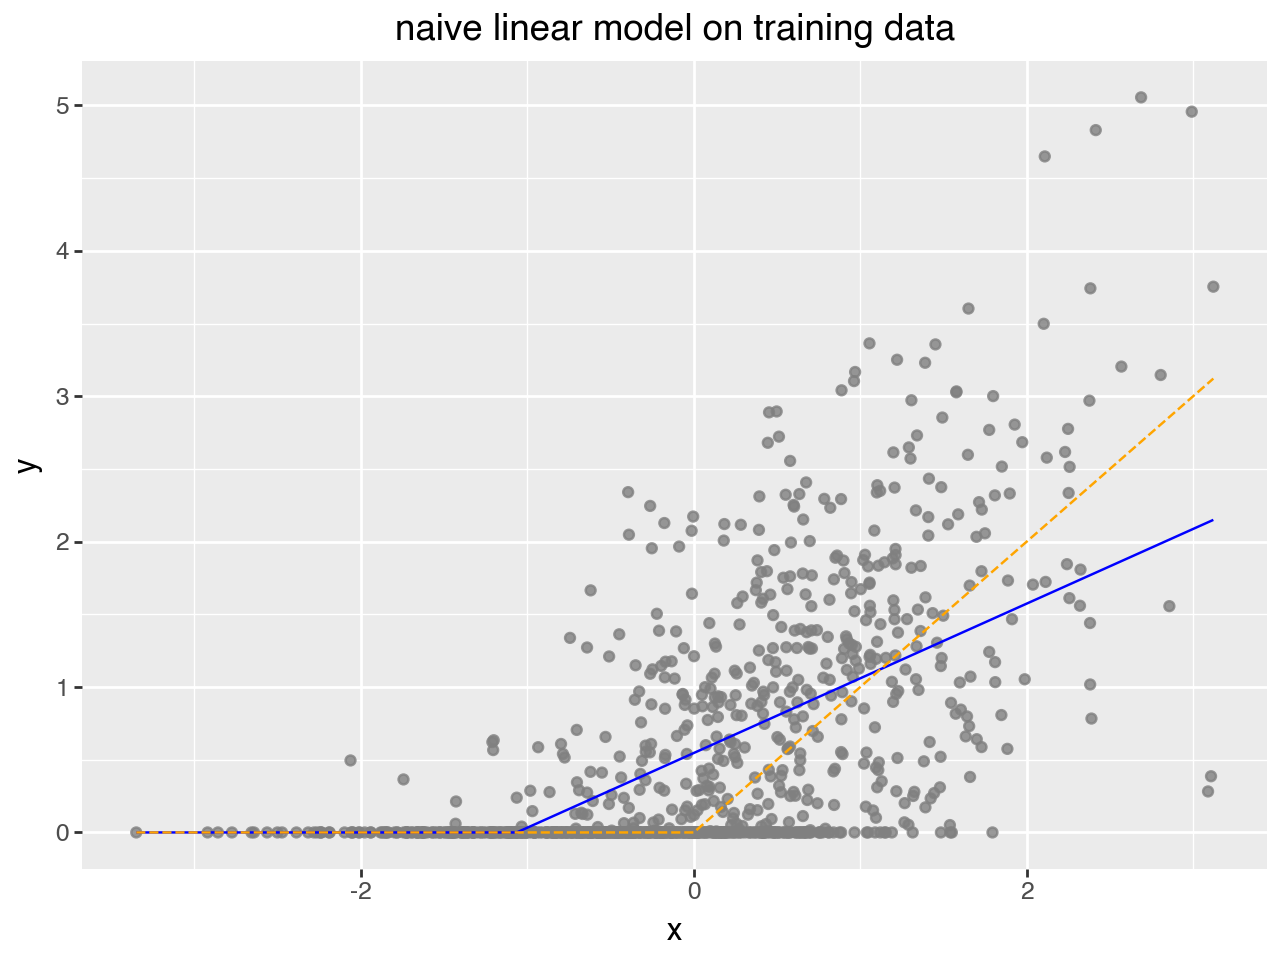

In [6]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) + 
    geom_line(
        mapping=aes(y='ypred0'),
        color="blue") + 
    geom_line(
        mapping=aes(y='concept'),
        color="orange", linetype='--') + 
    ggtitle("naive linear model on training data")
)

In [7]:
stan_model_src = """
data {
  int<lower=0> N_positive;   // number of positive observations
  int<lower=0> N_zero;       // number of zeros observations
  vector[N_positive] p_pos;  // observed predictions (to be adjusted to match outcomes)
  vector[N_positive] y_pos;  // observed outcomes
  vector[N_zero] p_zero;     // observed predictions (to be adjusted to match zero outcomes)
}
parameters {
  real a;               // regression slope
  real b;               // regression intercept
  real<lower=0> sigma;  // variance
}
model {
      // basic priors
  a ~ normal(0, 10);
  b ~ normal(0, 10);
  sigma ~ chi_square(1);
      // Tobit style model structure
  // y_pos ~ normal(a * p_pos + b, sigma);
  target += normal_lpdf(y_pos | a * p_pos + b, sigma);
  target += normal_lcdf( 0 | a * p_zero + b, sigma);
}
"""

# target += adds to log probability, and stan maximizes
# see https://mc-stan.org/docs/2_18/reference-manual/increment-log-prob-section.html

In [8]:
# build model
stan_file = 'tobit_tmp.stan'
with open(stan_file, 'w', encoding='utf8') as file:
    file.write(stan_model_src)
# instantiate the model object
model = CmdStanModel(stan_file=stan_file)

model

CmdStanModel: name=tobit_tmp
	 stan_file=/Users/johnmount/Documents/work/Examples/linear_regression_w_zeros/tobit_tmp.stan
	 exe_file=/Users/johnmount/Documents/work/Examples/linear_regression_w_zeros/tobit_tmp
	 compiler_options=stanc_options={}, cpp_options={}

In [9]:
pos_positions = traind['y'] > 0
p_pos = list(traind['ypred0'][pos_positions])
y_pos = list(traind['y'][pos_positions])
p_zero = list(traind['ypred0'][pos_positions == False])

In [10]:
data_str = f"""
{{
"N_positive" : {len(p_pos)},
"N_zero" : {len(p_zero)},
"p_pos" : {p_pos},
"y_pos" : {y_pos},
"p_zero" : {p_zero}
}}
"""

print(data_str)


{
"N_positive" : 477,
"N_zero" : 523,
"p_pos" : [1.074885339018591, 1.3897973349637143, 0.5809094326809312, 0.9888425985575152, 1.476281614431481, 0.8750178207655368, 1.3088869262112972, 0.5715175198550643, 0.14795003245565302, 1.0102688727359213, 0.20301973252747246, 0.43242913913513226, 0.6862447706498189, 0.7644810769784999, 0.661939309719601, 1.397894832168288, 1.1623788552332006, 1.1685466438001937, 0.8722138967217699, 0.9461679810957063, 1.4957403081284206, 0.4874244678926414, 0.7488808848607325, 0.41191890346141957, 1.2322808633912166, 1.1964170843225173, 0.9110870287250117, 0.10134878742374775, 0.8560930788155288, 1.1348924226483186, 1.0019674527035796, 0.7608933018219955, 1.5601483522986634, 0.5972808867316904, 0.8228537308758008, 1.0886438133549474, 0.4243877304900508, 0.5157708040281237, 0.9525393998723148, 0.6208796649705898, 1.1773680026920845, 1.0010576023986852, 0.7637071369630477, 1.701537352328975, 0.7838550279246566, 0.7475590902851317, 0.5209509945331896, 1.73828801

In [11]:
data_file = "tobit_tmp.json"
with open(data_file, 'w', encoding='utf8') as file:
    file.write(data_str)

In [12]:
fit = model.sample(
    data=data_file,
    show_progress=False,
    show_console=False,
    )

In [13]:
res = fit.draws_pd()

In [14]:
res

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b,sigma
0,-937.136,0.999847,0.319834,3.0,15.0,0.0,938.288,2.14926,-1.28665,1.018730
1,-938.515,0.968638,0.319834,3.0,7.0,0.0,938.773,2.10211,-1.29701,1.068590
2,-938.052,0.992650,0.319834,3.0,15.0,0.0,942.192,2.28452,-1.44357,1.083430
3,-937.453,0.999866,0.319834,3.0,7.0,0.0,938.174,2.24502,-1.41349,1.067650
4,-937.691,0.990803,0.319834,3.0,15.0,0.0,938.231,2.28655,-1.45746,1.062540
...,...,...,...,...,...,...,...,...,...,...
3995,-937.150,0.958588,0.371189,2.0,7.0,0.0,939.130,2.12031,-1.28832,1.012810
3996,-937.295,0.970870,0.371189,3.0,11.0,0.0,937.827,2.24856,-1.42473,1.049630
3997,-937.700,0.925078,0.371189,4.0,15.0,0.0,938.503,2.30796,-1.44763,1.030330
3998,-939.854,0.843785,0.371189,3.0,11.0,0.0,942.463,1.99054,-1.22585,1.007170


In [15]:
a = res['a'].mean()
b = res['b'].mean()

(a, b)

(2.1970605875, -1.3527242449999999)

In [16]:
traind['Tobit prediction'] = np.maximum(0, a * traind['ypred0'] + b)

traind

,x,y,concept,ypred0,Tobit prediction
0,1.028857,1.909897,1.028857,1.074885,1.008864
1,1.641920,0.797920,1.641920,1.389797,1.700745
2,1.146720,0.000000,1.146720,1.135428,1.141879
3,-0.973180,0.000000,0.000000,0.046500,0.000000
4,-1.392800,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
995,-1.086436,0.000000,0.000000,0.000000,0.000000
996,-0.508474,1.210484,0.000000,0.285205,0.000000
997,0.513753,0.000000,0.513753,0.810292,0.427536
998,-0.203761,0.000000,0.000000,0.441727,0.000000


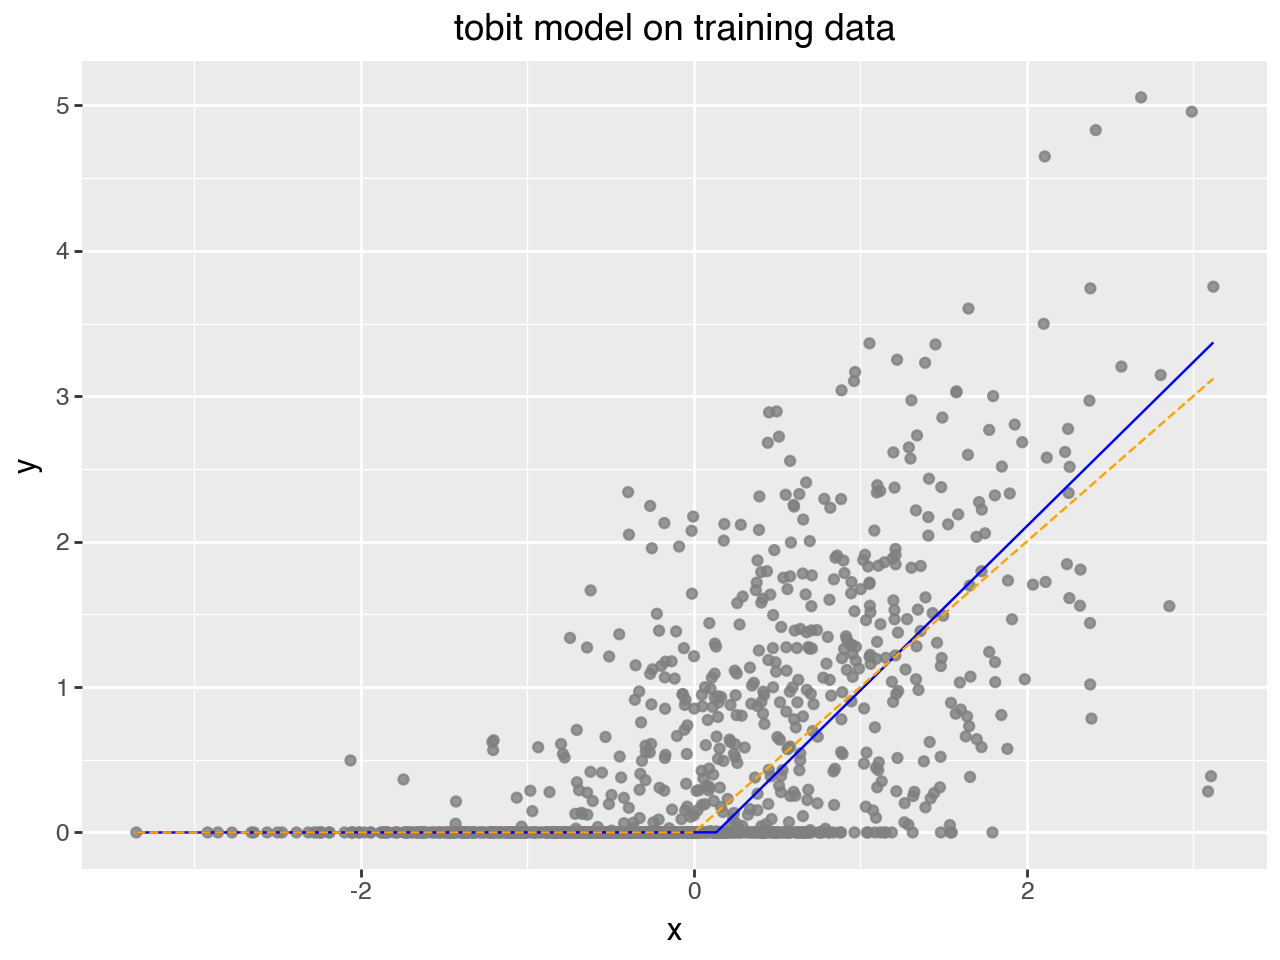

In [17]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x', y='y')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) +
    geom_line(
        mapping=aes(y='Tobit prediction'),
        color="blue") +
    geom_line(
        mapping=aes(y='concept'),
        color="orange", linetype='--') + 
    ggtitle("tobit model on training data")
)

In [18]:
consider_pos_for_lm = traind['ypred0'] > 0  # note: do get a better fit for traind['y'] > 0 cut, but that ignores data near zero.
lm = LinearRegression()
lm.fit(
    traind.loc[consider_pos_for_lm, ['ypred0']],
    traind.loc[consider_pos_for_lm, 'y'],
)
traind['linear prediction (prediction correction cut)'] = np.maximum(0, lm.predict(traind.loc[:, ['ypred0']]))

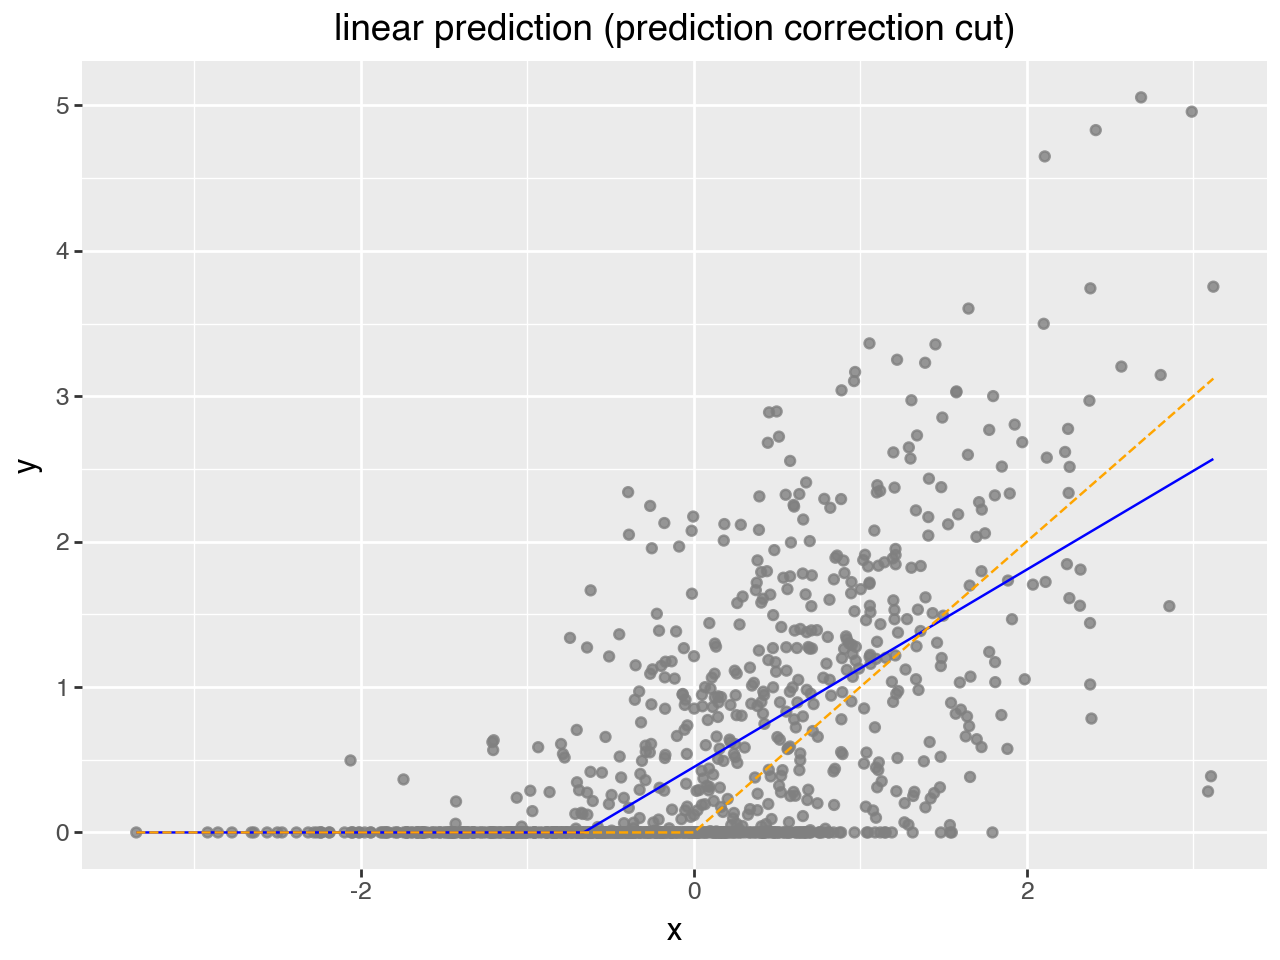

In [19]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x', y='y')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) +
    geom_line(
        mapping=aes(y='linear prediction (prediction correction cut)'),
        color="blue") +
    geom_line(
        mapping=aes(y='concept'),
        color="orange", linetype='--') + 
    ggtitle("linear prediction (prediction correction cut)")
)

In [20]:
(lm.coef_, lm.intercept_)

(array([1.32169906]), -0.27274097800051067)

In [21]:
consider_pos_for_lm_p = traind['y'] > 0
lm = LinearRegression()
lm.fit(
    traind.loc[consider_pos_for_lm_p, ['ypred0']],
    traind.loc[consider_pos_for_lm_p, 'y'],
)
traind['linear prediction (target threshold cut)'] = np.maximum(0, lm.predict(traind.loc[:, ['ypred0']]))

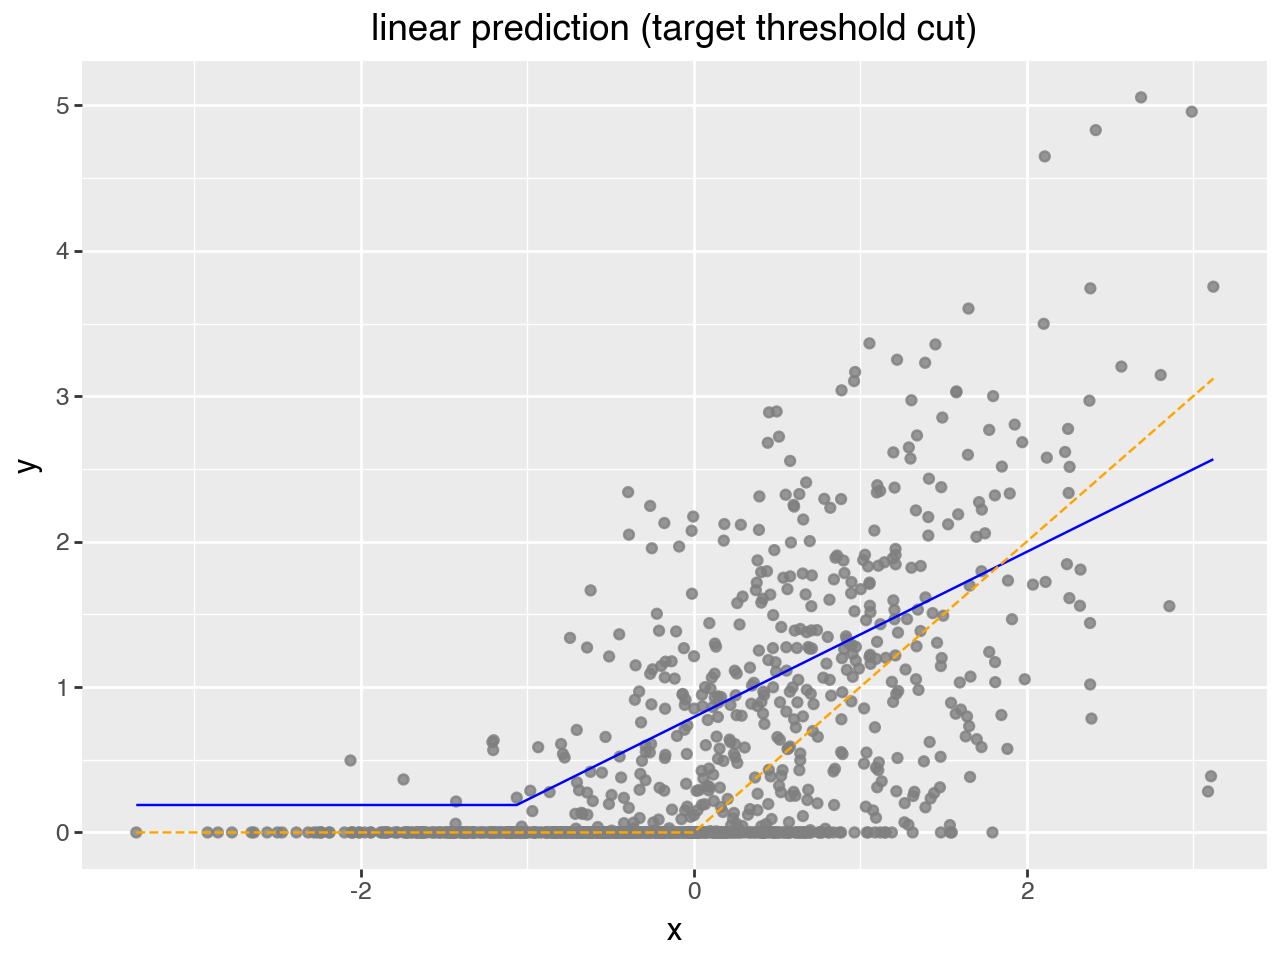

In [22]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x', y='y')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) +
    geom_line(
        mapping=aes(y='linear prediction (target threshold cut)'),
        color="blue") +
    geom_line(
        mapping=aes(y='concept'),
        color="orange", linetype='--') + 
    ggtitle("linear prediction (target threshold cut)")
)